<a href="https://colab.research.google.com/github/matthewpecsok/imbd_tf/blob/main/imbd_sentiment_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## imbd sentiment analysis
## dnn with 2 hidden layers with various neurons
## binary classification

This notebook uses the IMBD dataset to model sentiment with movie reviews. It is a binary classification problem. The final val dataset accuracy is ~ 89% for the best model. In this model I attempted to set the hyperparameters with a parameter grid and wrote my own code for the implementation rather than relying on packages. 

In [40]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
import gc


In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [3]:
word_index = tf.keras.datasets.imdb.get_word_index()

In [4]:
word_index['fawn']

34701

In [5]:
# why in the world it's indexed by word?
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])

In [6]:
reverse_word_index[4]

'of'

In [7]:
reverse_word_index[1]

'the'

In [8]:
min([max(sequence) for sequence in X_train])

394

In [9]:
pd.DataFrame(X_train)

,0
0,"[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, ..."
1,"[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463,..."
2,"[1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 5..."
3,"[1, 4, 2, 2, 33, 2804, 4, 2040, 432, 111, 153,..."
4,"[1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637, 1..."
...,...
24995,"[1, 14, 9, 6, 2758, 20, 21, 1517, 7, 2078, 5, ..."
24996,"[1, 4679, 2784, 299, 6, 1042, 37, 80, 81, 233,..."
24997,"[1, 11, 6, 230, 245, 6401, 9, 6, 1225, 446, 2,..."
24998,"[1, 1446, 7079, 69, 72, 3305, 13, 610, 930, 8,..."


In [10]:
np.sum(y_train)/y_train.shape[0]

0.5

# encode fun

In [11]:
def vector_seq(seq,dim=10000):
  res = np.zeros((len(seq),dim))
  for i, seq in enumerate(seq):
    res[i,seq] = 1.
  return(res)

# encode

In [12]:
X_train = vector_seq(X_train)
X_test = vector_seq(X_test)

we have an array of 25,000 rows and 10,000 columns. columns are words, rows are documents

In [13]:
y_train.dtype

dtype('int64')

In [14]:
type(y_train)

numpy.ndarray

In [15]:
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

# relu activation testing

In [16]:
y_train.dtype

dtype('float32')

In [17]:
type(y_train)

numpy.ndarray

In [18]:
np.dot((1,2),(2,3))

8

In [19]:
tf.keras.activations.relu(np.dot((1,2,3,4),(2,3,4,5)))

<tf.Tensor: shape=(), dtype=int64, numpy=40>

In [20]:
tf.keras.activations.relu(np.dot((1,2,3,4),(2,3,4,5)))

<tf.Tensor: shape=(), dtype=int64, numpy=40>

In [21]:
tf.keras.activations.relu(-5)

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [22]:
tf.keras.activations.relu(5)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

# model building

## model function

In [49]:
def model_create(param_grid,X_train,y_train,verbose):
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Dense(param_grid['neurons'],activation=tf.keras.activations.relu,input_shape=(10000,)))
  model.add(tf.keras.layers.Dense(param_grid['neurons'],activation=tf.keras.activations.relu))
  model.add(tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid))

  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=param_grid['learning_rate']),loss=tf.keras.losses.binary_crossentropy,metrics=['accuracy'])

  history = model.fit(X_train,y_train,validation_split=.2, epochs=10,verbose=verbose)
  return history,model,np.round(np.max(history.history['val_accuracy']),2)


## grid setups

In [44]:
from sklearn.model_selection import ParameterSampler
from scipy.stats.distributions import expon
import numpy as np

## number of grid rows
grid_rows = 10

# this code generates far more 
# parameter options than needed
# so we use the parameter sampler to grab some  

rng = np.random.RandomState(0)
param_grid = {'neurons':np.linspace(1,1000,1000), 'learning_rate': np.linspace(0.001,0.1,50)}
param_list = list(ParameterSampler(param_grid, n_iter=grid_rows,
                                   random_state=rng))

param_list

[{'learning_rate': 0.0050408163265306125, 'neurons': 733.0},
 {'learning_rate': 0.08787755102040817, 'neurons': 568.0},
 {'learning_rate': 0.08585714285714287, 'neurons': 614.0},
 {'learning_rate': 0.09191836734693878, 'neurons': 892.0},
 {'learning_rate': 0.043428571428571434, 'neurons': 244.0},
 {'learning_rate': 0.06161224489795919, 'neurons': 404.0},
 {'learning_rate': 0.0656530612244898, 'neurons': 104.0},
 {'learning_rate': 0.08383673469387756, 'neurons': 994.0},
 {'learning_rate': 0.04140816326530612, 'neurons': 758.0},
 {'learning_rate': 0.09393877551020409, 'neurons': 885.0}]

In [104]:
np.linspace(2,10,9)

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [45]:
model_output = pd.DataFrame()

In [50]:
for i in param_list:
  history,model,val_acc = model_create(i,X_train,y_train,1)
  print(val_acc)
  new_row = dict()
  new_row = {'model':model,'history':history,'acc':val_acc}
  model_output = model_output.append(new_row,ignore_index=True)

model_output = model_output.join(pd.DataFrame(param_list))

model_output

Epoch 1/10
625/625 [==============================] - 51s 81ms/step - loss: 0.7334 - accuracy: 0.8125 - val_loss: 0.3052 - val_accuracy: 0.8850
Epoch 2/10
625/625 [==============================] - 50s 81ms/step - loss: 0.2195 - accuracy: 0.9227 - val_loss: 0.4331 - val_accuracy: 0.8832
Epoch 3/10
625/625 [==============================] - 50s 81ms/step - loss: 0.1638 - accuracy: 0.9523 - val_loss: 0.4611 - val_accuracy: 0.8822
Epoch 4/10
625/625 [==============================] - 51s 81ms/step - loss: 0.1215 - accuracy: 0.9659 - val_loss: 1.6910 - val_accuracy: 0.8552
Epoch 5/10
625/625 [==============================] - 51s 82ms/step - loss: 0.1149 - accuracy: 0.9782 - val_loss: 2.1050 - val_accuracy: 0.8796
Epoch 6/10
625/625 [==============================] - 51s 81ms/step - loss: 0.0764 - accuracy: 0.9872 - val_loss: 2.8747 - val_accuracy: 0.8814
Epoch 7/10
625/625 [==============================] - 51s 81ms/step - loss: 0.0659 - accuracy: 0.9930 - val_loss: 5.0698 - val_accuracy:

,acc,history,model
0,0.88,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...
1,0.78,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...
2,0.83,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...
3,0.82,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...
4,0.89,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...
5,0.87,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...
6,0.88,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...
7,0.77,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...
8,0.88,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...
9,0.82,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...


In [41]:
gc.collect()

73

In [83]:
model_output

,acc,history,model
0,0.88,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...
1,0.78,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...
2,0.83,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...
3,0.82,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...
4,0.89,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...
5,0.87,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...
6,0.88,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...
7,0.77,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...
8,0.88,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...
9,0.82,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...


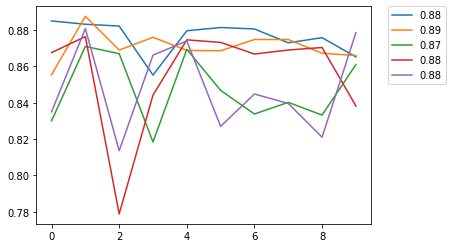

In [100]:


for index, row in model_output[model_output['acc']>.85].iterrows():
  plt.plot(row['history'].history['val_accuracy'],label=row['acc'])
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)




In [94]:
model_output = model_output.join(pd.DataFrame(param_list))

In [105]:
model_output[model_output['acc']>.85]

,acc,history,model,neurons,learning_rate
0,0.88,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,733.0,0.005041
4,0.89,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,244.0,0.043429
5,0.87,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,404.0,0.061612
6,0.88,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,104.0,0.065653
8,0.88,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,758.0,0.041408


In [107]:
model.save('/content/drive/MyDrive/Colab Notebooks/imbd/imbd_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/imbd/imbd_model/assets
